# Whose Costs?

### Introduction

This blog tackles a real world problem: given  information on an individual and their specific loan request, should a bank offer this person a loan? I will conduct an exploration of the data to determine which features in the dataset are the best predictors of a person's loan status (whether they will default on their loan, or not). Using logistic regression, I will determine a weight vector to use in a linear score function. Then, with the only goal of maximizing profit, I will choose a threshold value: individuals with scores below this value will be offered a loan by the mythical Liz Bank, and those with scores above this value will be denied. However, a model created with the sole goal of maximizing profit is bound to make harsh judgements and marginialize groups. At the end of this post, I'll evaluate to what extent this is true.

In [12]:
# import relevent packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

First, let's grab the data. Our dataset has 12 features and 22,907 entries. Our predictor variable is `loan_status`: a 1 indicates that this person defaulted on the loan and the bank lost money (bad!), and a 0 means they didn't default.

In [13]:
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)
df_train = df_train.dropna()
df_train

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10
6,21,21700,RENT,2.0,HOMEIMPROVEMENT,D,5500,14.91,1,0.25,N,2
...,...,...,...,...,...,...,...,...,...,...,...,...
26059,36,150000,MORTGAGE,8.0,EDUCATION,A,3000,7.29,0,0.02,N,17
26060,23,48000,RENT,1.0,VENTURE,A,4325,5.42,0,0.09,N,4
26061,22,60000,RENT,0.0,MEDICAL,B,15000,11.71,0,0.25,N,4
26062,30,144000,MORTGAGE,12.0,PERSONAL,C,35000,12.68,0,0.24,N,8


### Explore Data


Let's make a summary table and 2 visualizations to explore our data. In this process, we want to begin to determine which features may be good predictors of loan status. 

First, let's look at the mean loan amount for different home ownership statuses. Unsurprisingly, people with mortgages had a high mean loan amount of ~10,600. This makes sense, as their loan may be the mortgage itself, or these individuals' lack of disposable income may lead them to take loans for other purposes as well. People who rent and own houses had lower mean loan amounts around $8,000 - $9,000.

In [14]:
table = df_train.groupby(['person_home_ownership']).agg("loan_amnt").mean().reset_index()
table

,person_home_ownership,loan_amnt
0,MORTGAGE,10620.177719
1,OTHER,11305.194805
2,OWN,9051.955782
3,RENT,8912.191822


Next, I made a scatterplot illustrating loan status depending on loan interest rate and loan amount. From the graph, I was able to infer a decision boundary for loan interest rate: >12.5% and people tend to default on their loans, <12.5% and people tend not to. Curiously, it was challenging to see a pattern when considering loan amount.

[Text(0.5, 0, ' Loan Interest Rate '),
 Text(0, 0.5, ' Loan Amount'),
 Text(0.5, 1.0, 'Defaults based on Loan Interest Rate and Loan Amount')]

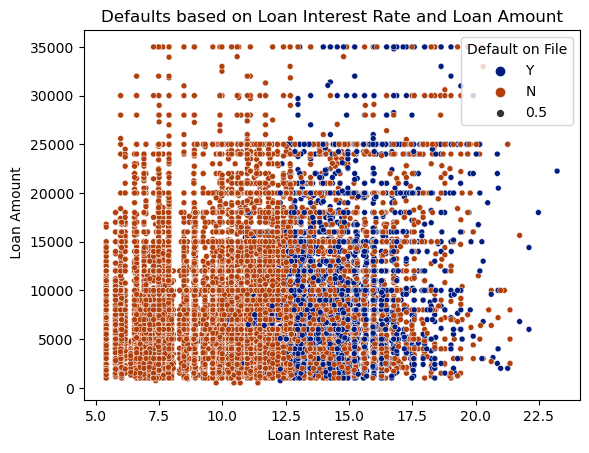

In [15]:
sns.set_palette("dark")
plot1 = sns.scatterplot(df_train, 
                        x = "loan_int_rate", 
                        y = "loan_amnt", 
                        hue = "cb_person_default_on_file", 
                        size = 0.5).set(xlabel = " Loan Interest Rate ",
                                        ylabel = " Loan Amount",
                                        title = "Defaults based on Loan Interest Rate and Loan Amount")

plt.legend(title = "Default on File")

plot1

Finally, these histograms helped me understand how purpose of loans change with age. Unsurprisingly, people in their twenties tend to take out loans for education, with people in their late twenties making venture loans to start businesses. With age, loans transition for medical and personal purposes.

/Users/lizrightmire/anaconda3/envs/ml-0451/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lizrightmire/anaconda3/envs/ml-0451/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lizrightmire/anaconda3/envs/ml-0451/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lizrightmire/anaconda3/envs/ml-0451/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

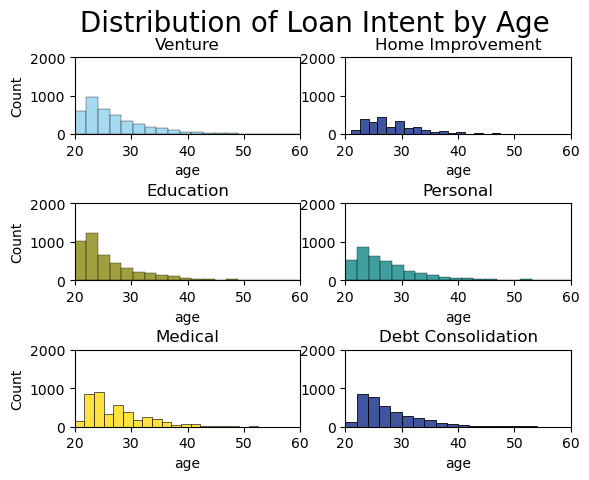

In [16]:
fig, axs = plt.subplots(3,2)
plt.title("Distribution of Loan Intent by Age")
plt.subplots_adjust(hspace = 0.9)

sns.histplot(data = df_train[df_train['loan_intent'] == "VENTURE"], x = "person_age", color="skyblue", ax = axs[0,0], bins = 60).set(title = "Venture", ylim = (0,2000), xlim = (20,60), xlabel = "age")
sns.histplot(data = df_train[df_train['loan_intent'] == "EDUCATION"], x = "person_age", color="olive", ax = axs[1,0], bins = 60).set(title = "Education", ylim = (0,2000), xlim = (20,60), xlabel = "age")
sns.histplot(data = df_train[df_train['loan_intent'] == "MEDICAL"], x = "person_age", color="gold", ax = axs[2,0], bins = 35).set(title = "Medical", ylim = (0,2000), xlim = (20,60), xlabel = "age")
sns.histplot(data = df_train[df_train['loan_intent'] == "HOMEIMPROVEMENT"], x = "person_age", ax = axs[0,1], bins = 25).set(title = "Home Improvement", ylim = (0,2000), xlim = (20,60), ylabel = None, xlabel = "age")
sns.histplot(data = df_train[df_train['loan_intent'] == "PERSONAL"], x = "person_age", color="teal", ax = axs[1,1], bins = 60).set(title = "Personal", ylim = (0,2000), xlim = (20,60), ylabel = None, xlabel = "age")
sns.histplot(data = df_train[df_train['loan_intent'] == "DEBTCONSOLIDATION"], x = "person_age", ax = axs[2,1], bins = 25).set(title = "Debt Consolidation", ylim = (0,2000), xlim = (20,60), ylabel = None, xlabel = "age")

fig.suptitle(' Distribution of Loan Intent by Age ', fontsize=20)
plt.show()

### Build a Model

Now it's time to build a model. First, one-hot-encode the qualitative columns in the training set and drop features not permitted in the mdoel (loan status -- the predictor, and loan grade)

In [17]:
from sklearn.preprocessing import LabelEncoder

# before one-hot-encoding, make copy of data for later visualization
df_for_viz = df_train.copy()

# label-encode qualitative features
le = LabelEncoder()
for label in ["loan_intent", "cb_person_default_on_file"]:
    df_train[label] = le.fit_transform(df_train[label])

# manually one-hot encode to force more logical order
df_train['person_home_ownership'] = df_train['person_home_ownership'].replace('OTHER', 0)
df_train['person_home_ownership'] = df_train['person_home_ownership'].replace('RENT', 1)
df_train['person_home_ownership'] = df_train['person_home_ownership'].replace('MORTGAGE', 2)
df_train['person_home_ownership'] = df_train['person_home_ownership'].replace('OWN', 3)

y_train = df_train["loan_status"]
X_train = df_train.drop(columns=['loan_status', 'loan_grade'])
X_train

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,27,98000,1,3.0,1,11750,13.47,0.12,1,6
2,22,36996,1,5.0,1,10000,7.51,0.27,0,4
3,24,26000,1,2.0,3,1325,12.87,0.05,0,4
4,29,53004,2,2.0,2,15000,9.63,0.28,0,10
6,21,21700,1,2.0,2,5500,14.91,0.25,0,2
...,...,...,...,...,...,...,...,...,...,...
26059,36,150000,2,8.0,1,3000,7.29,0.02,0,17
26060,23,48000,1,1.0,5,4325,5.42,0.09,0,4
26061,22,60000,1,0.0,3,15000,11.71,0.25,0,4
26062,30,144000,2,12.0,4,35000,12.68,0.24,0,8


What number of features, and which ones, are most effective in a model to predict loan status? To answer this question, I turned to logistic regression. Utilizing the combinations function from itertools, I fit a logistic regression model with 5 cross-validation batches for each combination of features. I began with `NUMFEATURES = 2` to test couples of features and found that `person_home_ownership` and `loan_percent_income` produced the highest score of 0.849. Adjusting `NUMFEATURES` to 3 and 4 produced highest scores of 0.484, so I deduced that those two features to be the simplest and most effecetive. 

In [18]:
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

pd.set_option('max_colwidth', 10000)
NUMFEATURES = 2

cols = X_train.columns

score_df_columns = ['features', 'score', 'weights']
score_df = pd.DataFrame(columns = score_df_columns)

for combo in combinations(cols, NUMFEATURES):
  combo = list(combo)
  
  # Logistic Regression
  LR = LogisticRegression(max_iter = 20000000000)
  LR.fit(X_train[combo], y_train)  
  LRscore = cross_val_score(LR, X_train[combo], y_train, cv = 5).mean()
  score_df.loc[len(score_df.index)] = [combo, LRscore, LR.coef_]  

score_df = score_df.sort_values(by='score', ascending=False).head(10)
score_df


,features,score,weights
21,"[person_home_ownership, loan_percent_income]",0.848736,"[[-1.0098629403833108, 8.271824027284113]]"
39,"[loan_int_rate, loan_percent_income]",0.823416,"[[0.2896471726415302, 8.417607957665085]]"
32,"[loan_intent, loan_percent_income]",0.819269,"[[-0.1108135938796114, 8.2548348300199]]"
27,"[person_emp_length, loan_percent_income]",0.819138,"[[-0.04604467360459407, 8.17718472200731]]"
6,"[person_age, loan_percent_income]",0.815471,"[[-0.0058903490094554785, 8.195442809295034]]"
43,"[loan_percent_income, cb_person_cred_hist_length]",0.815340,"[[8.201924752324944, -0.007641209561773739]]"
20,"[person_home_ownership, loan_int_rate]",0.814292,"[[-0.9816330580330728, 0.2767376475314839]]"
42,"[loan_percent_income, cb_person_default_on_file]",0.813769,"[[8.373163550192576, 1.0910615242300115]]"
12,"[person_income, loan_amnt]",0.808006,"[[-4.057354027170065e-05, 0.0001065591015240086]]"
31,"[loan_intent, loan_int_rate]",0.803990,"[[-0.10705093453352543, 0.27916038916611374]]"


From the `LogisticRegression.coef_` features, I was able to find the weights to use in my score function.

In [19]:
weights = score_df.iloc[0]["weights"][0]
weights

array([-1.00986294,  8.27182403])

### Find a Threshold

Extract the two desired features for the `X_train`dataset, and set the `y_train` dataset to be the predictor variable -- `loan_status`

In [20]:
X_train = df_train[['person_home_ownership', 'loan_percent_income']]
y_train = df_train['loan_status']

Before we continue with making our model, let's quickly check if it makes sense that these two variables are effective in modeling loan status. It turns out that yes, we see clear differences in `loan_percent_income` in the different `person_home_ownership` groups for those who did and didn't default on their loans.

AttributeError: 'numpy.int64' object has no attribute 'startswith'

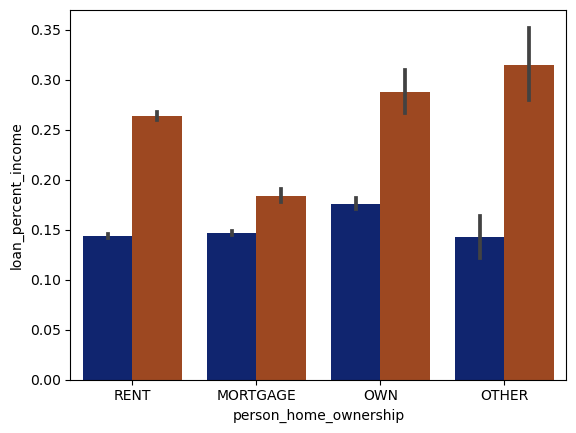

In [21]:
sns.set_palette("dark")
plot1 = sns.barplot(df_for_viz, 
                        x = "person_home_ownership", 
                        y = "loan_percent_income", 
                        hue = "loan_status")

plt.legend(title = "Default on File")


The linear score for each entry of `X_train` is just `X_train` @ `weights`, where @ represents matrix multiplication.

In [ ]:
def linear_score(X, w):
    return X@w

s = linear_score(X_train, weights)

Let's take a look at the scores we produced. All scores are between -3 and 5, with most being around 0. The distribution of scores roughly takes the form of a bell curve.

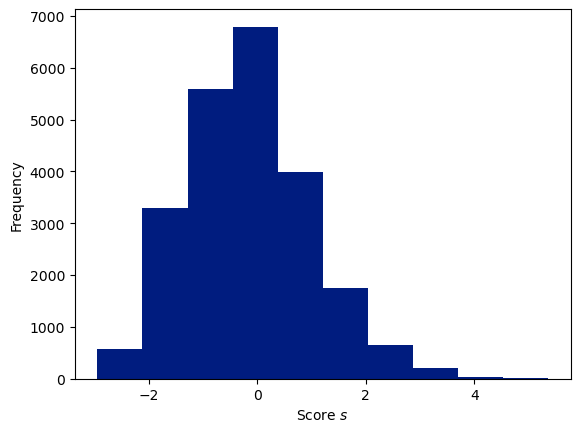

In [ ]:
hist = plt.hist(s)
labs = plt.gca().set(xlabel = r"Score $s$", ylabel = "Frequency") 

What should the threshold be to maximize profit? To answer this question, I chose to copy `df_train` into `df_profit`. This way, I could add a column `y_pred`, which is `False` if the person's score is less than the threshold and `True` if it is greater than or equal to the threshold. With a for loop, different values of threshold `t` can be considered. Another column, outcome, labels entries as true negatives, false negatives, false positives, and true positives. That way, each person's profit contribution to the bank can be stored in a final column: `profit`. True positives and false positives don't contribute any profit (neither positive nor negative) because they won't be offered a loan in the first place -- these people are expected to default. To find the average profit per loan, divide by the combined number of false negatives and true negatives

In [ ]:
df_profit = df_train

T = np.linspace(s.min()-0.1, s.max()+0.1, 101)
profits = []

for t in T:

    y_pred = (s >= t)

    df_profit['y_pred'] = y_pred
    df_profit['outcome'] = "empty"
    df_profit['profit'] = 0.0

    # label entries as true/false negative/positive
    df_profit.loc[(df_profit['y_pred'] == False) & (df_profit['loan_status'] == 0), 'outcome'] = 'TN' # gain money
    df_profit.loc[(df_profit['y_pred'] == False) & (df_profit['loan_status'] == 1), 'outcome'] = 'FN' # lose money
    df_profit.loc[(df_profit['y_pred'] == True) & (df_profit['loan_status'] == 0), 'outcome'] = 'FP' # won't give loan
    df_profit.loc[(df_profit['y_pred'] == True) & (df_profit['loan_status'] == 1), 'outcome'] = 'TP' # won't give loan
    
    # true positive -- bank makes money!
    df_profit.loc[df_profit['outcome'] == 'TN', 'profit'] = df_profit['loan_amnt'] * (1 + (0.25 * (df_profit['loan_int_rate'] / 100)))**10 - (df_profit['loan_amnt'])

    # False negative -- bank loses money
    df_profit.loc[df_profit['outcome'] == 'FN', 'profit'] = df_profit['loan_amnt'] * (1 + (0.25 * (df_profit['loan_int_rate'] / 100)))**3 - (1.7*df_profit['loan_amnt'])

    # total numbers of false negatives and true negatives, to calculate avg profit/ accepted loan (pred = False)
    numFN = df_profit.loc[df_profit['outcome'] == 'FN'].size
    numTN = df_profit.loc[df_profit['outcome'] == 'TN'].size
    
    if (numFN + numTN != 0):
        totalprof = sum(df_profit['profit']) / (numFN + numTN)
        profits.append(totalprof)
    else:
        profits.append(0)

Plotting the average profit per loan results for each threshold value shows a maximum when threshold = -2. The expected profit per loan is around $110 at this value. 

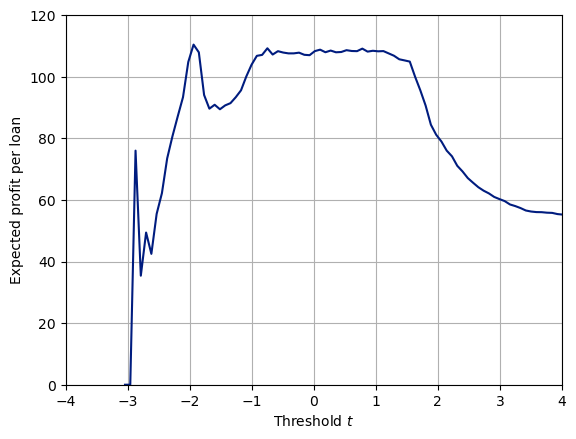

In [ ]:
import matplotlib.ticker as ticker

plt.plot(T, profits)
plt.gca().set(ylim = (0, 120), xlim = (-4, 4))
labs = plt.gca().set(xlabel = r"Threshold $t$", ylabel = "Expected profit per loan")
plt.grid(True)

### Evalute your Model from the Bank's Perspective

Let's run our model on the test set, with a threshold value of -2.

In [ ]:
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test = pd.read_csv(url)
df_test =df_test.dropna()

df_test['person_home_ownership'] = df_test['person_home_ownership'].replace('OTHER', 0)
df_test['person_home_ownership'] = df_test['person_home_ownership'].replace('RENT', 1)
df_test['person_home_ownership'] = df_test['person_home_ownership'].replace('MORTGAGE', 2)
df_test['person_home_ownership'] = df_test['person_home_ownership'].replace('OWN', 3)


X_test = df_test[['person_home_ownership', 'loan_percent_income']]

,person_home_ownership,loan_percent_income
0,1,0.02
1,2,0.29
2,1,0.06
3,2,0.15
4,1,0.08
...,...,...
6511,2,0.23
6513,1,0.29
6514,3,0.22
6515,2,0.09


In [ ]:
t = -2
s_test = linear_score(X_test, weights)
y_pred_test = (s_test >= t)

In [ ]:
df_profit = df_test.copy()

df_profit['y_pred'] = y_pred_test
df_profit['outcome'] = "empty"
df_profit['profit'] = 0.0

df_profit.loc[(df_profit['y_pred'] == False) & (df_profit['loan_status'] == 0), 'outcome'] = 'TN' # gain money
df_profit.loc[(df_profit['y_pred'] == False) & (df_profit['loan_status'] == 1), 'outcome'] = 'FN' # lose money
df_profit.loc[(df_profit['y_pred'] == True) & (df_profit['loan_status'] == 0), 'outcome'] = 'FP' # won't give loan
df_profit.loc[(df_profit['y_pred'] == True) & (df_profit['loan_status'] == 1), 'outcome'] = 'TP' # won't give loan
    
# true positive -- bank makes money!
df_profit.loc[df_profit['outcome'] == 'TN', 'profit'] = df_profit['loan_amnt'] * (1 + (0.25 * (df_profit['loan_int_rate'] / 100)))**10 - (df_profit['loan_amnt'])

# False negative -- bank loses money
df_profit.loc[df_profit['outcome'] == 'FN', 'profit'] = df_profit['loan_amnt'] * (1 + (0.25 * (df_profit['loan_int_rate'] / 100)))**3 - (1.7*df_profit['loan_amnt'])

numFN = df_profit.loc[df_profit['outcome'] == 'FN'].size
numTN = df_profit.loc[df_profit['outcome'] == 'TN'].size
    
totalprofit = sum(df_profit['profit']) / (numFN + numTN)

print(totalprofit)

139.52875179012145


The expected profit per borrower is ~$140. This is $30 larger, or 27% larger, than the average profit per loan on the test set.

### Evaluate model from Borrower's Perspective

Our model produces great profits for the bank. But how does it function from the borrower's perspective?

The following table shows one thing very clearly: this model does NOT grant loans to many individuals. In order to maximize the profit per loan, the model only predicts people to not default if they have a score <-2. Considering the histogram of scores from earlier, we know that a very small subset of people in our training set had scores <-2. In our test set, that's only 174 people out of the total 5731. 

In [ ]:
df_profit.groupby('y_pred').size()

y_pred
False     174
True     5557
dtype: int64

Let's consider: is it more difficult for people in certain age groups to access credit? The following histogram indicates that no, our model accepts people from different age groups at equal rates.

/Users/lizrightmire/anaconda3/envs/ml-0451/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lizrightmire/anaconda3/envs/ml-0451/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'Distribution of Loan Intent by Age'}, xlabel='person_age', ylabel='Count'>

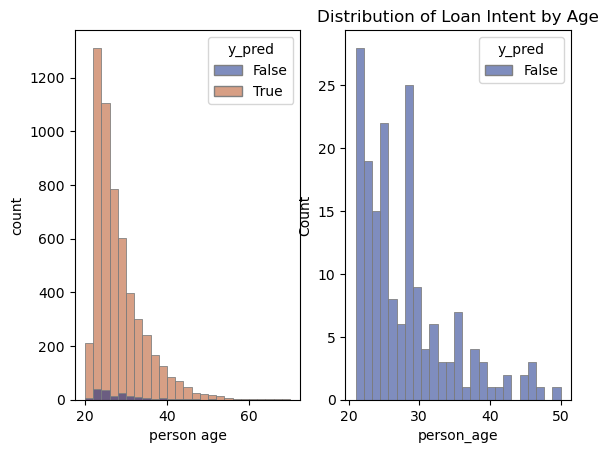

In [ ]:

fig, axs = plt.subplots(1,2)
plt.title("Distribution of Loan Intent by Age")
plt.subplots_adjust(hspace = 0.9)

# is it more difficult for people in certain age groups to access credit?
sns.histplot(data = df_profit, x = "person_age", hue = "y_pred", bins = 25, edgecolor = 'grey', ax = axs[0]).set(xlabel = "person age", ylabel = "count")
sns.histplot(data = df_profit[df_profit['y_pred'] == False], x = "person_age", hue = "y_pred", bins = 25, edgecolor = 'grey', ax=axs[1])

However, considering the following table, there are unfair trends. People 50+ are predicted to default 100% of the time and are consequently offered no loans by our model. It is easiest for people aged 40-50 to receive a loan; although they are expected to default 95.45% of the time, this is the lowest percentage of any age group.

In [ ]:
bins = [20, 30, 40, 50, 60, 70] 
df_profit['Age Group'] = pd.cut(df_profit['person_age'], bins=bins, labels=['20-30', '30-40', '40-50', '50-60', '60-70'])
summary_stats = df_profit.groupby('Age Group').aggregate('y_pred').mean()
summary_stats

/var/folders/nd/3yjvm85j3rq1vhh53yn6cy0r0000gn/T/ipykernel_63697/368891113.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = df_profit.groupby('Age Group').aggregate('y_pred').mean()


Age Group
20-30    0.969766
30-40    0.970776
40-50    0.954545
50-60    1.000000
60-70    1.000000
Name: y_pred, dtype: float64

Now to consider: is it more difficult for people to get loans in order to pay for medical expenses? Medical loans are the 2nd most challenging to secure with our model, after Debt Consolidation.

In [ ]:
# predictions for default in groups
df_profit.groupby('loan_intent').aggregate('y_pred').mean()

loan_intent
DEBTCONSOLIDATION    0.997788
EDUCATION            0.963435
HOMEIMPROVEMENT      0.965909
MEDICAL              0.971109
PERSONAL             0.970942
VENTURE              0.950207
Name: y_pred, dtype: float64

When compared to the actual rate of default, people in the test set defaulted on debt consolidation loans 28.76% of the time, and defaulted on medical loans 28.43% of the time.

In [ ]:
# actual rate of default:
df_profit.groupby('loan_intent').aggregate('loan_status').mean()

loan_intent
DEBTCONSOLIDATION    0.287611
EDUCATION            0.167517
HOMEIMPROVEMENT      0.250000
MEDICAL              0.284250
PERSONAL             0.220441
VENTURE              0.146266
Name: loan_status, dtype: float64

Finally, I am curious how a person's income level impacts the ease with which they can access credit under my decision system. To answer this question, I made the following table which shows the percentages of people in each income group who would be granted a loan by my algorithm. Unfortunately, only 2.38% of people making <$50,000 would be offered a loan by my model, whereas people making $150,000 - 200,000 would be offered a loan 5.13% of the time. People making $200,000+ would be granted loans at a much higher rate: 9.19%.

In [ ]:
# percentages of people predicted not to default

# Define the income groups
bins = [0, 50000, 100000, 150000, 200000, np.inf]
labels = ['0-50,000', '50,000-100,000', '100,000-150,000', '150,000-200,000', '200,000+']

# Create a new column for income groups
df_profit['income_group'] = pd.cut(df_profit['person_income'], bins=bins, labels=labels)

# Group by income_group and y_pred and count the number of rows
grouped = df_profit.groupby(['income_group', 'y_pred']).size()

# Calculate the percentage of rows where y_pred is False in each income group
percentage = grouped.xs(False, level='y_pred') / grouped.groupby(level='income_group').sum() * 100

print(percentage.reset_index())

      income_group         0
0         0-50,000  2.378073
1   50,000-100,000  3.041216
2  100,000-150,000  4.570384
3  150,000-200,000  5.128205
4         200,000+  9.195402


/var/folders/nd/3yjvm85j3rq1vhh53yn6cy0r0000gn/T/ipykernel_63697/537452620.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_profit.groupby(['income_group', 'y_pred']).size()
/var/folders/nd/3yjvm85j3rq1vhh53yn6cy0r0000gn/T/ipykernel_63697/537452620.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage = grouped.xs(False, level='y_pred') / grouped.groupby(level='income_group').sum() * 100


### Conclusion

In this exercise, I blindly set out with one goal: maximizing profit. I intentionally put my opinions aside to determine what the outcome would be if I truly just tried to make a model that makes the most money for a bank. Consequently, I used the "best" features for modeling loan status and set a very low threshold value that offered loans to very very few people -- only ones rated very low chance of default. These people, unsurprisingly, tended to have high income, be in their 30s and 40s, and be requesting loans for venture use. 

Ok, so I've made this brutal algorithm, now I can finally bring my brain back into the equation and think about what I've done. The people the mythical Liz Bank is offering loans to... don't NEED the loans as badly as the others. They're already rich! This hardly feels fair -- people who have more money to begin with can get loans for more money, while others can't?

Now I need to describe how I like to consider fairness. I like thinking about it in terms of equality vs. equity. In an equal world, everyone is treated the same no matter their circumstances. In an equitable world, people with less advantages are given a "boost" so that people have near equal opportunities. I think that a fair world is an equitable world, but not necessarily an equal world.

![citation:https://mostly.ai/blog/we-want-fair-ai-algorithms-but-how-to-define-fairness](fairness.jpg){width=50%}

This was a valable exercise. My mom works on a loan committee at a small local bank, and now I am curious how she and her colleagues determine who to grant loans to in our community. I am excited to ask her more about this, any models they use in their decisions, and maybe offer her some new perspective on the issue. This exercise reminded me of the importance of staying connected to the problem I'm solving with ML: things get dicey when there's only one goal in mind (e.g: maximize profit!)